# First model

Classifies image into [0...10]

In [8]:
#custom neural networks
import neural_networks as ann
#other imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [10]:
batch_size_train = 128
batch_size_test = 1000


train_loader = DataLoader(MNIST('mnist_data/', train=True, download=True,
                             transform=Compose([
                               ToTensor(),
                               Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = DataLoader(MNIST('mnist_data/', train=False, download=True,
                             transform=Compose([
                               ToTensor(),
                               Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

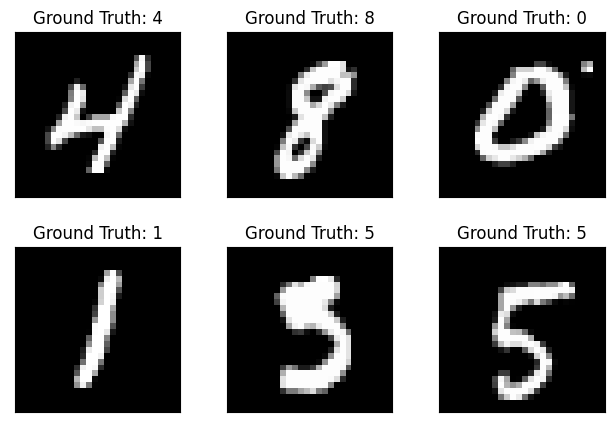

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [14]:
def train_model(num_epochs,model,train_loader,test_loader,learning_rate,device="cpu"):
    class_names = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    model.train()
    for epoch in tqdm(range(num_epochs)):
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            loss = loss_func(model(x), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    correct_pred = {name: 0 for name in class_names}
    total_pred = {name: 0 for name in class_names}

    model.eval()
    for x, y in test_loader:
        images, labels = x.to(device), y.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1

    for name, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[name]
        print("Accuracy for class {} is: {:.1f} %".format(name, accuracy))

In [15]:
#PARAMETERS
learning_rate=1e-3
num_epochs=10

conv_net = ann.ConvNet()
train_model(num_epochs,conv_net,train_loader,test_loader,learning_rate)


Accuracy for class 0 is: 99.8 %
Accuracy for class 1 is: 99.4 %
Accuracy for class 2 is: 99.7 %
Accuracy for class 3 is: 98.5 %
Accuracy for class 4 is: 99.2 %
Accuracy for class 5 is: 98.8 %
Accuracy for class 6 is: 98.1 %
Accuracy for class 7 is: 98.9 %
Accuracy for class 8 is: 98.2 %
Accuracy for class 9 is: 98.6 %


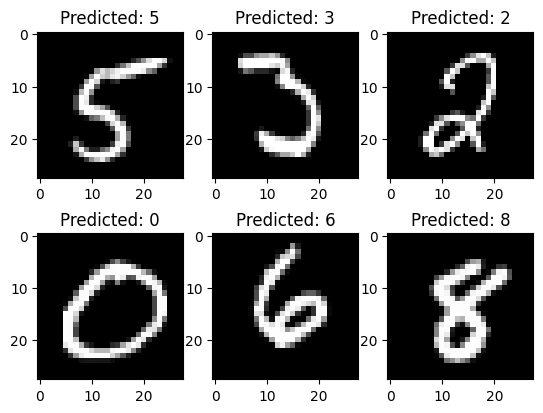

In [34]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].detach().view(28, 28), cmap='gray', interpolation='none')
    predicted_class = torch.argmax(conv_net(example_data)[i]).item()
    plt.title(f"Predicted: {predicted_class}")
plt.show()

# Second Model

Takes the pretrained model and adds one last layer to make it a binary classification

#### Load the MNIST data as binary classification instead of multiclass

In [36]:
# Specify the target digit for binary classification
target_digit = 9
# Define transformations
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# Create binary classification train and test loaders
binary_train_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=True, transform=transform, target_digit=target_digit),
                          batch_size=batch_size_train, shuffle=True)
binary_test_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=False, transform=transform, target_digit=target_digit),
                         batch_size=batch_size_test, shuffle=True)

In [37]:
def train_binary_model(num_epochs,model,train_loader,test_loader,learning_rate,device="cpu"):
    class_names = (0, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    model.train()
    for epoch in tqdm(range(num_epochs)):
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            loss = loss_func(model(x), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    correct_pred = {name: 0 for name in class_names}
    total_pred = {name: 0 for name in class_names}

    model.eval()
    for x, y in test_loader:
        images, labels = x.to(device), y.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1

    for name, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[name]
        print("Accuracy for class {} is: {:.1f} %".format(name, accuracy))

#### Add extra layer

In [39]:
#PARAMETERS
learning_rate=1e-3
num_epochs=10

extra_layer = ann.Extra_layer()
model = nn.Sequential(conv_net, extra_layer)

train_binary_model(num_epochs,model,binary_train_loader,binary_test_loader,learning_rate)


Accuracy for class 0 is: 99.9 %
Accuracy for class 1 is: 98.6 %


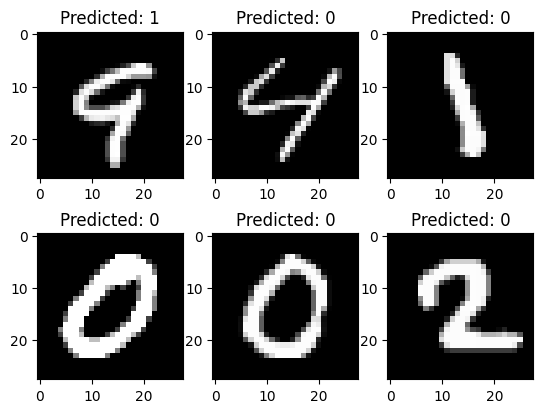

In [40]:
examples = enumerate(binary_test_loader)
batch_idx, (example_data, example_targets) = next(examples)
first_one = (example_targets==1).nonzero()[0]


for i in range(6):
    plt.subplot(2,3,i+1)
    i += first_one.item()
    plt.imshow(example_data[i].detach().view(28, 28), cmap='gray', interpolation='none')
    predicted_class = torch.argmax(model(example_data)[i]).item()
    plt.title(f"Predicted: {predicted_class}")
plt.show()

# Autoencoder

Will be used for Croco

In [44]:
def train_autoencoder_model(num_epochs,model,train_loader,test_loader,learning_rate,device="cpu"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.MSELoss()

    model.train()
    for epoch in tqdm(range(num_epochs)):
        for i, (x, _) in enumerate(train_loader):
            x = x.to(device)
            loss = loss_func(model(x), x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        for i, (x, _) in enumerate(test_loader):
            x = x.to(device)
            loss = loss_func(model(x), x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [45]:
#PARAMETERS
learning_rate=1e-3
num_epochs=30

autoencoder = ann.Autoencoder()

train_autoencoder_model(num_epochs,autoencoder,train_loader,test_loader,learning_rate,device="cpu")

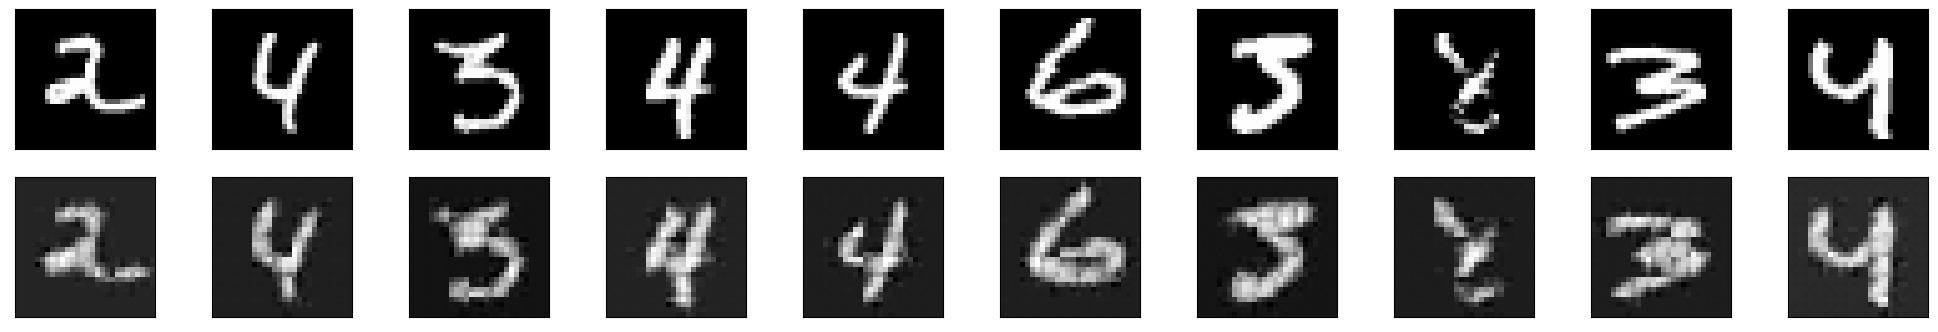

In [46]:
examples = enumerate(binary_test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# plot the first ten input images and then reconstructed images
fig = plt.figure(figsize=(25,4))

# input images on top row, reconstructions on bottom
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(example_data[i].view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(autoencoder(example_data[i]).detach().view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# Save all the models

In [47]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model_checkpoint.pth')
torch.save(autoencoder.state_dict(), 'autoencoder_checkpoint.pth')